In [9]:
# Testing Paru

import cv2
import numpy as np
import requests

def prepare_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img.tolist()

image_path = './img_test.png'
image = prepare_image(image_path)

data = {"instances": image}  # Konversi ke daftar Python agar dapat di-serialize menjadi JSON

url = 'https://medical-math-models.onrender.com/v1/models/model_paru:predict'

response = requests.post(url, json=data)

predict = response.json()
class_labels = np.array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Normal', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'])
predicted_label = class_labels[np.argmax(predict['predictions'])]

predicted_label

KeyboardInterrupt: 

In [86]:
import json, requests
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer

# Load the tokenizer word index from the JSON file
with open('tokenizer.json', 'r') as f:
    word_index = json.load(f)

# Create a new tokenizer and set the word index
tokenizer = Tokenizer(num_words=20000, oov_token='x')
tokenizer.word_index = word_index

# Load the classes from JSON files and reconstruct the MultiLabelBinarizer instances
mlbs_loaded = {}

for key in ['DU', 'DS', 'OB']:
    with open(f'labels/classes_{key}.json', 'r') as f:
        classes = json.load(f)
    
    # Create a new MultiLabelBinarizer and fit it with the loaded classes
    mlb = MultiLabelBinarizer()
    mlb.fit([classes])
    mlbs_loaded[key] = mlb

def paragraph_id(data):
    gender = "Laki-laki" if data["gender"] == "L" else "Perempuan"

    def get_value(key, unit):
        try:
            return f"{float(data[key])} {unit}"
        except (KeyError, ValueError):
            return "-"

    kalium = get_value("Kalium", "mmol/L")
    natrium = get_value("Natrium", "mmol/L")
    kreatinin = get_value("Kreatinin", "mg/dL")
    pemeriksaan = lambda key: f"Pemeriksaan {key}: {', '.join(data[key])}." if key in data else ""
    HR = f"-" if data["HR"] == "-" else f"{int(data['HR'])} bpm"
    LVEF = f"-" if data['LVEF'] == "-" else f"{float(data['LVEF'])}%"
    paragraf = [
        f"Seorang pasien {gender} berusia {int(data['usia'])} tahun dengan berat badan {int(data['weight'])} kg dan tinggi badan {int(data['height'])} cm.",
        f"Pasien memiliki keluhan: {data['subjektif']}." if data['subjektif'] != "Tidak ada keluhan" else "Pasien tidak memiliki keluhan.",
        f"Hasil pemeriksaan menunjukkan LVEF sebesar {LVEF}.",
        pemeriksaan("Cor"),
        pemeriksaan("Pulmo"),
        pemeriksaan("Abdomen"),
        pemeriksaan("Ext"),
        pemeriksaan("Lain-lain") if data.get("Lain-lain", ["-"])[0] != "-" else "",
        f"Tekanan darah (TD) pasien adalah {data['TD']} mmHg dengan denyut jantung (HR) {HR}.",
        f"Kadar Kalium {kalium}, Natrium {natrium}, dan Kreatinin {kreatinin}.",
    ]
    return " ".join(filter(None, paragraf))

In [87]:



# Predict function
def url_and_threshold(key):
    return {
        "DU": ('https://testdocker-x7tv.onrender.com/v1/models/model_diagnosa_utama:predict', 0.2),
        "DS": ('https://testdocker-x7tv.onrender.com/v1/models/model_diagnosa_sekunder:predict', 0.5),
        "OB": ('https://testdocker-x7tv.onrender.com/v1/models/model_obat:predict', 0.2),
    }.get(key)

def predict(texts, key, tokenizer, max_len=128):
    # Tokenisasi dan padding teks
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)

    url, threshold = url_and_threshold(key)
    response = requests.post(url, json={"instances": padded_sequences.tolist()})
    response.raise_for_status()

    probabilities = response.json()['predictions'][0]
    return (np.array(probabilities) > threshold).astype(int)

# Example usage
data = {'usia': 55.0,
  'gender': 'L',
  'weight': 64.0,
  'height': 175.0,
  'LVEF': '39.60',
  'subjektif': 'Tidak ada keluhan',
  'Subjective': 'No complaints',
  'Cor': ['S1 S2 Single reguler', 'murmur (-)'],
  'Pulmo': ['ves (+/+)', 'ronkhi (-/-)', 'wheezing (-/-)'],
  'Abdomen': ['BU (+) Normal', 'Distensi (-)'],
  'Ext': ['hangat (+/+)', 'edema (-/-)'],
  'Lain-lain': ['DOE (+)', 'PND (-)', 'orthopnea (-)'],
  'TD': '110/70',
  'HR': 60.0,
  'Kalium': '-',
  'Natrium': 138.0,
  'Kreatinin': '1.40'}


data_paragraph = paragraph_id(data)
pred = predict(data_paragraph, "OB", tokenizer)

In [91]:
def transform_label(mlbs, key, label):
    return list(mlbs[key].inverse_transform(np.array([label]))[0])

transform_label(mlbs_loaded, "OB", pred)

['Allopurinol 1 x 100 mg',
 'Asetosal 1 x 80 mg',
 'Clopidogrel 1 x 75 mg',
 'Furosemide tab 1 x 40 mg',
 'Lansoprazole 1 x 30 mg',
 'Simvastatin 1 x 20 mg',
 'Simvastatin 1 x 40 mg',
 'Spironolakton 1 x 25 mg']

In [2]:
import json, requests
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer


# Load the tokenizer word index from the JSON file
with open('./tokenizer.json', 'r') as f:
    word_index = json.load(f)

# Create a new tokenizer and set the word index
tokenizer = Tokenizer(num_words=20000, oov_token='x')
tokenizer.word_index = word_index

# Load the classes from JSON files and reconstruct the MultiLabelBinarizer instances
mlbs_loaded = {}

for key in ['DU', 'DS', 'OB']:
    with open(f'labels/classes_{key}.json', 'r') as f:
        classes = json.load(f)
    
    # Create a new MultiLabelBinarizer and fit it with the loaded classes
    mlb = MultiLabelBinarizer()
    mlb.fit([classes])
    mlbs_loaded[key] = mlb


def parameter_convert(data):
    prefixes = ["cor", "abdomen", "ext", "pulmo", "tambahan"]
    result = {}

    for key, value in data.items():
        for prefix in prefixes:
            if key.startswith(prefix):
                result.setdefault(prefix, []).append(value)
                break
        else:
            result[key] = value

    return result

def paragraph_id(data):
    gender = "Laki-laki" if data["gender"] == "L" else "Perempuan"

    def get_value(key, unit):
        try:
            return f"{float(data[key])} {unit}"
        except (KeyError, ValueError):
            return "-"

    kalium = get_value("kalium", "mmol/L")
    natrium = get_value("natrium", "mmol/L")
    kreatinin = get_value("kreatinin", "mg/dL")
    pemeriksaan = lambda key: f"Pemeriksaan {key}: {', '.join(data[key])}." if key in data else ""
    HR = f"-" if data["hr"] == "-" else f"{int(data['hr'])} bpm"
    LVEF = f"-" if data['lvef'] == "-" else f"{float(data['lvef'])}%"
    paragraf = [
        f"Seorang pasien {gender} berusia {int(data['usia'])} tahun dengan berat badan {int(data['bb'])} kg dan tinggi badan {int(data['tb'])} cm.",
        f"Pasien memiliki keluhan: {data['keluhan']}." if data['keluhan'] != "Tidak ada keluhan" else "Pasien tidak memiliki keluhan.",
        f"Hasil pemeriksaan menunjukkan LVEF sebesar {LVEF}.",
        pemeriksaan("cor"),
        pemeriksaan("pulmo"),
        pemeriksaan("abdomen"),
        pemeriksaan("ext"),
        pemeriksaan("tambahan") if data.get("tambahan", ["-"])[0] != "-" else "",
        f"Tekanan darah (TD) pasien adalah {data['td']} mmHg dengan denyut jantung (HR) {HR}.",
        f"Kadar Kalium {kalium}, Natrium {natrium}, dan Kreatinin {kreatinin}.",
    ]
    return " ".join(filter(None, paragraf))

def url_and_threshold(key):
    return {
        "DU": ('https://medical-math-model-jantung.onrender.com/v1/models/du:predict', 0.2),
        "DS": ('https://medical-math-model-jantung.onrender.com/v1/models/ds:predict', 0.1),
        "OB": ('https://medical-math-model-jantung.onrender.com/v1/models/ob:predict', 0.2),
    }.get(key)

def predict_text(texts, key, tokenizer, max_len=128):
    # Tokenisasi dan padding teks
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)

    url, threshold = url_and_threshold(key)
    response = requests.post(url, json={"instances": padded_sequences.tolist()})
    response.raise_for_status()

    probabilities = response.json()['predictions'][0]
    return (np.array(probabilities) > threshold).astype(int), probabilities

def transform_label(mlbs, key, label):
    return list(mlbs[key].inverse_transform(np.array([label]))[0]), mlbs[key].classes_

In [10]:
data = {
    "biodata": {
        "bb": "123",
        "domisili": "123",
        "gender": "L",
        "lvef": "123",
        "nama": "123",
        "tb": "123",
        "usia": "123"
    },
    "parameter": {
        "abdomen1": "123",
        "cor1": "123",
        "ext1": "123",
        "hr": "123",
        "kalium": "123",
        "keluhan": "awdawd",
        "kreatinin": "123",
        "natrium": "123",
        "pulmo1": "123",
        "tambahan1": "123",
        "td": "123"
    }
}

biodata = data["biodata"]
parameter = data["parameter"]

datareq = biodata | parameter_convert(parameter)

data_paragraph = paragraph_id(datareq)

keys_model = 'DU'

pred, prob = predict_text(data_paragraph, keys_model, tokenizer)
label, labels = transform_label(mlbs_loaded, keys_model, pred)
prob, mlbs_loaded[keys_model].classes_

([0.999247909,
  0.00230535911,
  8.91159e-06,
  1.08905046e-11,
  1.0,
  7.30653732e-11],
 array(['ADHF Profile B', 'ADHF Profile C', 'CHF FC II', 'CHF FC III',
        'Congestive heart failure', 'Heart failure, unspecified'],
       dtype=object))

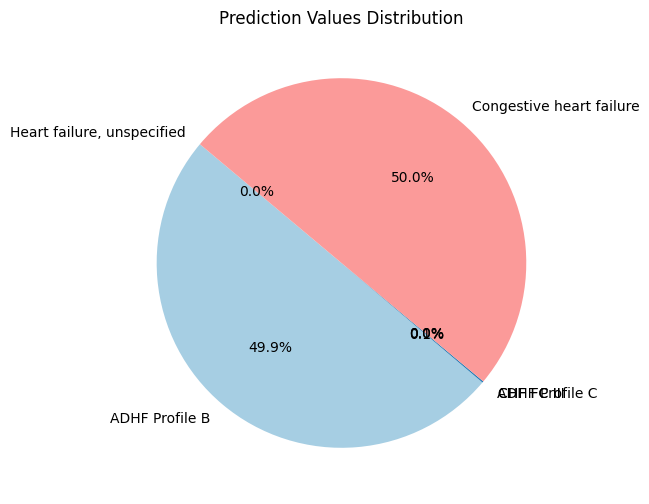

In [12]:
import matplotlib.pyplot as plt

# Data prediksi dan label
predictions = [0.999247909, 0.00230535911, 8.91159e-06, 1.08905046e-11, 1.0, 7.30653732e-11]
labels = ['ADHF Profile B', 'ADHF Profile C', 'CHF FC II', 'CHF FC III', 'Congestive heart failure', 'Heart failure, unspecified']

# Membuat pie chart
plt.figure(figsize=(10, 6))
plt.pie(predictions, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Prediction Values Distribution')
plt.show()
